In this version we control the linear dynamics by an open loop.  

Solver is optimize-then-discretize. 

Only consider control constraint.

结论：短时间预测有可控性问题，长时间预测有精度问题。预测时间过短，系统不可控，得到的控制几乎吃满约束，最终也无法将系统稳定；预测时间稍长，那因为梯度涉及一次前向传播和一次后向传播，误差会累积两次，计算得到的梯度跟真实梯度相差可能很大。而且若控制初值使得系统不稳定的话，系统在长时间演化后数值会爆炸，梯度是不可用的。高精度的格式可能可以缓解前者，但后者是需要从算法层面上解决的。

In [1]:
import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.axes3d import Axes3D
import controller
import matplotlib.pyplot as plt

In [2]:
def Q(t):
    result = np.array(
    [
        [1., 0.],
        [0., 1.]
    ]
    )
    return result
    
def R(t):
    result = np.array([0.1])
    return result
#R constructed by scale factor?

'''R = np.array([
    [1/2,0],[0,1/(0.2)]
])
R_scaler = 1. 
R *= R_scaler'''
F = np.array(
    [
        [1.,0.],
        [0.,1.]
    ]
)


In [3]:


A = np.array(
    [
        [0. , 0.1],
        [0. , 1.]
    ]
    )
B = np.array(
    [
        [0.],
        [0.5]
    ]
)
def f(x,u):
    return A@x + B@u

def nabla_x_f(x,u):
    return A

def nabla_x_phi(x,xd,u):
    return 2*F@(x-xd)

def nabla_x_l(x,xd,u,t):
    return 2*Q(t)@(x-xd)

def nabla_u_l(x,u,t):
    return 2*R(t)@u

def nabla_u_f(x,u):
    return B


In [4]:
def forward_integrator(x0,u,time_stops):
    x_list = [x0]
    for i in range(len(time_stops)-1):
        x_list.append(x_list[i] + f(x_list[i],u[i])*(time_stops[i+1]-time_stops[i]))
    return x_list

def backward_integrator(n_x_phi,n_x_f,n_x_l,x,xd,u,time_stops):
    p_list = [n_x_phi(x[-1],xd[-1],u[-1])]
    #print(n_x_phi(x[-1],xd[-1],u[-1]),x[-1],'!!!')
    for i in range(len(time_stops)-1,0,-1):
        p_list.append(
            p_list[-1] + (time_stops[i]-time_stops[i-1]) * (n_x_f(x[i],u[i]).T @ p_list[-1] + n_x_l(x[i],xd[i],u[i],time_stops[i]))
            )
    p_list.reverse()
    return p_list

def grad(x,u,p,n_u_l,n_u_f,time_stops):
    gd = []
    
    for i in range(len(x)):
        #print((n_u_f(x[i],u[i]).T).shape,p[i].shape)
        gd.append(n_u_l(x[i],u[i],time_stops[i])+n_u_f(x[i],u[i]).T @ p[i])
    
    return gd 

def grad_norm(gd,time_steps):
    norm = 0
    for i in range(len(gd)-1):
        norm += (time_steps[i+1]-time_steps[i])*((np.linalg.norm(gd[i])**2+np.linalg.norm(gd[i+1])**2)/2)
    return np.sqrt(norm)

def project_const(u,constraints):
    u_new = [np.clip(u[i],constraints[i][0],constraints[i][1]) for i in range(len(u))]
    return np.array(u_new).reshape(-1,1)

def projected_grad_descent(u_old,grad,stepsize,u_constraints):
    ''' 
    constraints:[[lower,upper],[lower,upper],...]
    '''
    u_new = []
    for i in range(len(u_old)):

        u_new.append(project_const(u_old[i]-stepsize*grad[i],u_constraints))
    return u_new 

In [5]:

x0 = np.array([[20.,-20.]]).reshape(-1,1)

xd = np.array(
    [
        [0],
        [0.]
    ]
)

u0 = np.array(
    [
        [0]
    ]
)

In [6]:
dt = 0.02
pred_horizon = [0,3]
disc_steps = 200
time_stops = np.linspace(pred_horizon[0],pred_horizon[1],disc_steps)

In [7]:

def pgd_solve(grad_tolerance=1e-6,max_iter=100):
    iter = 0 
    gd_norm = 1.
    xd_bar = [xd for i in range(disc_steps)]
    u_bar = [u0 for i in range(disc_steps)]
    while iter < max_iter and gd_norm > grad_tolerance:
        x_bar = forward_integrator(x0,u_bar,time_stops)
        p_bar = backward_integrator(nabla_x_phi,nabla_x_f,nabla_x_l,x_bar,xd_bar,u_bar,time_stops)

        grad_bar = grad(x_bar,u_bar,p_bar,n_u_f = nabla_u_f,n_u_l=nabla_u_l,time_stops = time_stops)
        
        
        u_bar = projected_grad_descent(u_bar,grad_bar,0.01,[[-100.0,100.0]])
        iter += 1
        gd_norm = grad_norm(grad_bar,time_stops)
        print('PGD at iteration: {}, grad_norm: {}'.format(iter,gd_norm))

    return u_bar,x_bar 

In [8]:
'''xd_bar = [xd for i in range(disc_steps)]
u_bar = [u0 for i in range(disc_steps)]
xb = forward_integrator(x0,u_bar,time_stops)
pb = backward_integrator(nabla_x_phi,nabla_x_f,nabla_x_l,xb,xd_bar,u_bar,time_stops)'''

'xd_bar = [xd for i in range(disc_steps)]\nu_bar = [u0 for i in range(disc_steps)]\nxb = forward_integrator(x0,u_bar,time_stops)\npb = backward_integrator(nabla_x_phi,nabla_x_f,nabla_x_l,xb,xd_bar,u_bar,time_stops)'

In [9]:
ub,xb = pgd_solve(max_iter =500)

PGD at iteration: 1, grad_norm: 8205.625116867774
PGD at iteration: 2, grad_norm: 3505.0096380222913
PGD at iteration: 3, grad_norm: 1606.968223300149
PGD at iteration: 4, grad_norm: 736.9257462311505
PGD at iteration: 5, grad_norm: 337.78390387657635
PGD at iteration: 6, grad_norm: 155.0073414365095
PGD at iteration: 7, grad_norm: 71.00158645870263
PGD at iteration: 8, grad_norm: 32.75352799388702
PGD at iteration: 9, grad_norm: 15.097394089586706
PGD at iteration: 10, grad_norm: 7.423181747417202
PGD at iteration: 11, grad_norm: 4.065868744587726
PGD at iteration: 12, grad_norm: 3.065559958774659
PGD at iteration: 13, grad_norm: 2.720972880398951
PGD at iteration: 14, grad_norm: 2.6763279578422177
PGD at iteration: 15, grad_norm: 2.642542692774083
PGD at iteration: 16, grad_norm: 2.637620334198724
PGD at iteration: 17, grad_norm: 2.6266419099414517
PGD at iteration: 18, grad_norm: 2.6199970009479148
PGD at iteration: 19, grad_norm: 2.6117208171748025
PGD at iteration: 20, grad_norm: 

In [10]:
xm = np.array(xb).squeeze(-1)
print(xm.shape)

(200, 2)


In [11]:
u_tilde = np.array(ub).squeeze(-1)

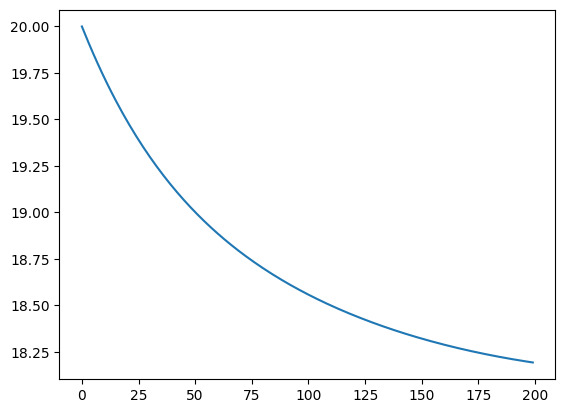

In [12]:
plt.plot(xm[:,0])
#plt.plot(u_tilde[:,0])

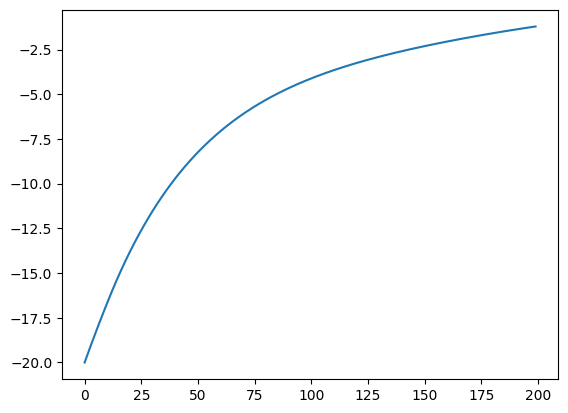

In [13]:
plt.plot(xm[:,1])

In [14]:
plt.plot(u_tilde[:,1])

IndexError: index 1 is out of bounds for axis 1 with size 1

In [ ]:
pb = np.array(pb).squeeze(-1)

In [ ]:
plt.plot(pb[:,1])

TypeError: list indices must be integers or slices, not tuple